Lets import all the pkgs needed

In [43]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import datetime

import matplotlib.pyplot as plt

We start by reading in the data

In [44]:
data = pd.read_csv("final_dataset_stocks.csv")
data.head()

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,...,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,...,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,...,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,...,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


We will drop the index column that came with the dataset 

In [45]:
data.drop(columns=['Unnamed: 0'], inplace=True)

we will drop the rows that includes na

In [46]:
#The rows with NaN are days when market was closed. I will be deleting those rows.
data.dropna(inplace=True)

In [47]:
data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Even though we have removed null values, there still might be wrong non-numeric values here. Let's look at those dtypes.

In [48]:
data.select_dtypes(include=[object])

,date,SP_Volume,interest_rate,yield_rate
2,2012-01-03,--,2.01,1.97
3,2012-01-04,--,2.08,2.00
4,2012-01-05,--,2.12,2.02
5,2012-01-06,--,2.09,1.98
8,2012-01-09,--,2.11,1.98
...,...,...,...,...
3601,2021-11-10,--,2.7,1.56
3602,2021-11-11,--,.,.
3603,2021-11-12,--,2.73,1.58
3606,2021-11-15,--,2.76,1.63


In [49]:
data['SP_Volume'].value_counts()

--    2486
Name: SP_Volume, dtype: int64

Since all values are null, we will drop this column.

In [50]:
data.drop(columns=['SP_Volume'], inplace=True)

Next, we can notice some values in columns 'interest_rate' and 'yeild_rate' are "."

Let us replace it by the next numeric value in the series.

In [51]:
#Replacing values in yield_curves
for i in range(len(data)):
  if data.iloc[i,-1] == '.':
    data.iloc[i,-1] = data.iloc[i + 1,-1] 

In [52]:
data.columns.get_loc("interest_rate")

16

In [53]:
#Replacing values in interest rate
for i in range(len(data)):
  if data.iloc[i,16] == '.':
    data.iloc[i,16] = data.iloc[i + 1,16] 

In [54]:
#Converting the above columns into float
data['yield_rate'] = data['yield_rate'].astype('float')
data['interest_rate'] = data['interest_rate'].astype('float')
df=data

In [55]:
#Finally lets convert date string to datetime format
#for i in range(len(data)):
  #data.iloc[i,0] = datetime.datetime.strptime(data.iloc[i,0], '%Y-%m-%d')

data['date'] = pd.to_numeric(pd.to_datetime(data['date']))

In [56]:




data.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,1325548800000000000,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,1325635200000000000,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,1325721600000000000,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,1325808000000000000,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,1326067200000000000,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,1277.83,1281.99,1274.55,2.11,16068.824,1.98


Now, let us split the data into X and y. Since we are trying to predict the price of the Closing price of the IBM stock, we will make our split accordingly.

In [57]:
X = data.drop(columns =['IBM_close'])
y = data.IBM_close.values

Using sklearn, we will create a train_test_split.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [59]:
#this converts the numeric date back to datetime (just to make the graph prettier)
#this is for actual date
for i in range(len(data)):
  your_timestamp = data.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  data.iloc[i,0] = date.date()
data.date = pd.to_datetime(data['date'])

#this is for the X_test
for i in range(len(X_test)):
  your_timestamp = X_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  X_test.iloc[i,0] = date.date()
X_test.date = pd.to_datetime(X_test['date'])
display(X_test)

,date,IBM_open,IBM_high,IBM_low,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
967,2014-08-24,134.5888,134.8842,134.1106,1723600.0,4563.720215,4571.140137,4547.779785,4557.350098,4557.350098,1.384620e+09,1997.92,1991.74,2001.95,1991.74,2.15,17743.227,2.39
886,2014-06-04,129.0926,130.0923,128.5753,2852200.0,4259.120117,4299.500000,4241.680176,4296.229980,4296.229980,1.926750e+09,1940.46,1928.52,1941.74,1922.93,2.18,17462.703,2.59
445,2013-03-20,145.0327,145.0599,143.0917,5830400.0,3228.169922,3237.570068,3215.689941,3222.600098,3222.600098,1.692260e+09,1545.80,1558.71,1558.71,1543.55,2.52,16629.050,1.95
3203,2020-10-07,117.2765,121.4349,116.2997,25269266.0,11443.349609,11448.230469,11384.330078,11420.980469,11420.980469,3.486530e+09,3446.83,3434.28,3447.28,3428.15,1.72,21477.597,0.78
856,2014-05-05,132.7047,132.7186,131.5370,3188700.0,4128.220215,4132.459961,4080.760010,4080.760010,4080.760010,1.850610e+09,1867.72,1883.69,1883.69,1867.72,2.16,17462.703,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,2019-09-02,115.1289,115.1727,113.8313,2827919.0,7906.439941,7940.370117,7847.319824,7874.160156,7874.160156,1.936210e+09,2906.27,2909.01,2914.39,2891.85,1.50,21505.012,1.47
1719,2016-09-14,116.0591,117.5860,115.2392,3662573.0,5178.100098,5254.779785,5176.250000,5249.689941,5249.689941,1.950940e+09,2147.26,2125.36,2151.31,2122.36,1.49,18775.459,1.71
2889,2019-11-28,115.4037,116.1984,114.9113,1825255.0,8682.009766,8697.320313,8664.040039,8665.469727,8665.469727,1.099090e+09,3140.98,3147.18,3150.30,3139.34,1.61,21694.458,1.78
2788,2019-08-19,115.4619,115.4960,113.3872,3018648.0,7989.359863,8010.580078,7948.089844,7948.560059,7948.560059,1.747580e+09,2900.51,2919.01,2923.63,2899.60,1.53,21505.012,1.55


# RF
below we will train the random forest model below.

We start by splitting the data using Train_test_split

In [70]:
#construct X,y
# X = df.drop(columns =['IBM_close'])
# y = df.IBM_close.values


#split the data into train test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# #Feature scaling for random forest 
# from sklearn.preprocessing import StandardScaler
XX_test = X_test
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# display(X_train)
# X_test = sc.transform(X_test)

we will trian the Random Forrest here 

In [71]:
#import a few things here 
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

In [62]:
# Create RF
# Here we use the default MSE for our criterion
rf = RandomForestRegressor(n_estimators=10000, max_depth=3, n_jobs=-1, random_state=1,max_features=6,min_samples_leaf=2)

# Now we'll train/test
rf.fit(X_train,y_train)
ypr = rf.predict(X_test)


cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
n_scores = cross_val_score(rf, X, y,scoring='neg_mean_squared_error' ,cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Negative MSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))






Negative MSE: -3.720 (0.400)


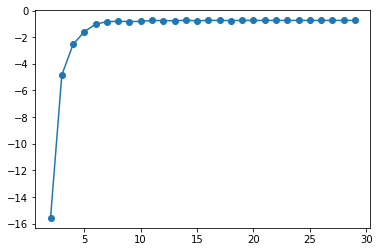

CV     -0.725725
XAX    14.000000
Name: 12, dtype: float64

In [72]:
# Create and fit trees from max_depth 2 to max_depth 30. Use 5-fold CV for each.
CV_score = []
for i in range(2,30):
    tree = RandomForestRegressor(n_estimators=10, max_depth=i, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,30,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

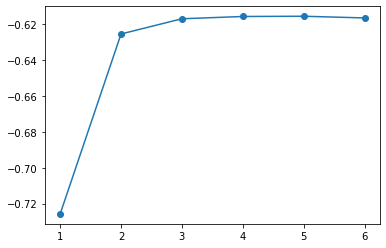

CV    -0.61547
XAX    5.00000
Name: 4, dtype: float64

In [73]:
    
# Create and fit trees from n_est 10 to n_est 100000. Use 5-fold CV for each.
CV_score = []
n_est = [10,100,1000,5000,6000,10000]
for est in n_est:
    tree = RandomForestRegressor(n_estimators=est, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())
    
# Plot the mean CV score vs. n_est

x_axis = np.arange(1,7,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()


# Report the optimal estimator

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

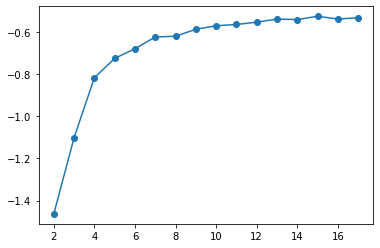

CV     -0.525691
XAX    15.000000
Name: 13, dtype: float64

In [74]:
# Create and fit trees from max_features 2 to max_features 18. Use 5-fold CV for each.
CV_score = []
for i in range(2,18):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=i,min_samples_leaf=2)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(2,18,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_feature

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

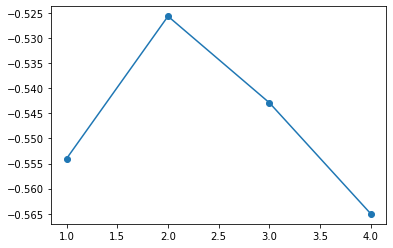

CV    -0.525691
XAX    2.000000
Name: 1, dtype: float64

In [75]:
# Create and fit trees from min_samples_leaf 1 to 5. Use 5-fold CV for each.
CV_score = []
for i in range(1,5):
    tree = RandomForestRegressor(n_estimators=10, max_depth=14, n_jobs=-1, random_state=1,max_features=15,min_samples_leaf=i)
    tree.fit(X_train,y_train)
    ypr = tree.predict(X_test)
    cvsc = cross_val_score(tree, X_train, y_train,scoring='neg_mean_squared_error', cv=5)
    CV_score.append(cvsc.mean())

# Plot the mean CV score vs. maximum depth 

x_axis = np.arange(1,5,1)
plt.scatter(x_axis,CV_score)
plt.plot(x_axis,CV_score)
plt.show()    

# Report the optimal max_depth

maxCV = pd.DataFrame(data={'CV':CV_score, 'XAX' :x_axis})
display(maxCV.iloc[maxCV['CV'].idxmax()])

In [76]:
rf = RandomForestRegressor(n_estimators=6000, max_depth=14, n_jobs=-1, random_state=1,max_features=5,min_samples_leaf=2)
#drop_train = X_train.drop(columns=['IBM_open'],inplace=True)
# X_train = data[:int(len(data)*0.8)]
# y_train = data.IBM_close[:int(len(data)*0.8)]
# X_train.drop(columns=['IBM_close'],inplace=True)
# X_test = data[int(len(data)*0.8):]
# y_test = data.IBM_close[int(len(data)*0.8):]
# X_test.drop(columns=['IBM_close'],inplace=True)
# drop_train = X_train
# display(drop_train)
# drop_train.drop(columns=['IBM_high'],inplace=True)
# drop_train.drop(columns=['IBM_open'],inplace=True)
#display(drop_train.head())
rf.fit(X_train, y_train)
ypr_rf = rf.predict(X_test)

# sum((ypr_rf-y_test)**2)/len(ypr_rf)



print(ypr)

[118.68474791 113.42019246 129.35099745 133.42319366 127.67561157
 117.96220195 135.06381543 113.10129449 108.54301857 114.76689123
 113.68871108 102.57969392 119.51440958 116.4895428  138.76935493
 118.68076614 115.70720813 115.66582684 137.8260627  110.03075151
 113.68512549 119.97912217  89.68308901 113.68094075 134.46881282
 115.33013058 128.88020475 121.74871355 114.0833777  120.65813621
 116.83266684 101.18763265 133.18148249 109.99629683  98.71089714
 136.2921437   94.7403229  130.41742571 118.32375071 119.52116191
 127.19914476 129.59004498 114.83190412 114.61668131 104.7469892
  99.72208127 113.24682503  88.64813306 108.46450903 130.77421396
 130.21717577 131.11951951 131.11037118 122.25557459 118.94265181
 115.07793068 125.8513767  129.4641717  111.24650054 123.94269774
 127.33289377 105.63605063 130.85290352 123.50276752 133.68247573
 114.84734391 124.45585992 115.2745083  126.65997187 115.95454739
 109.92447444 113.36351745  96.70271363 123.47851776 114.23640941
 112.438489

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


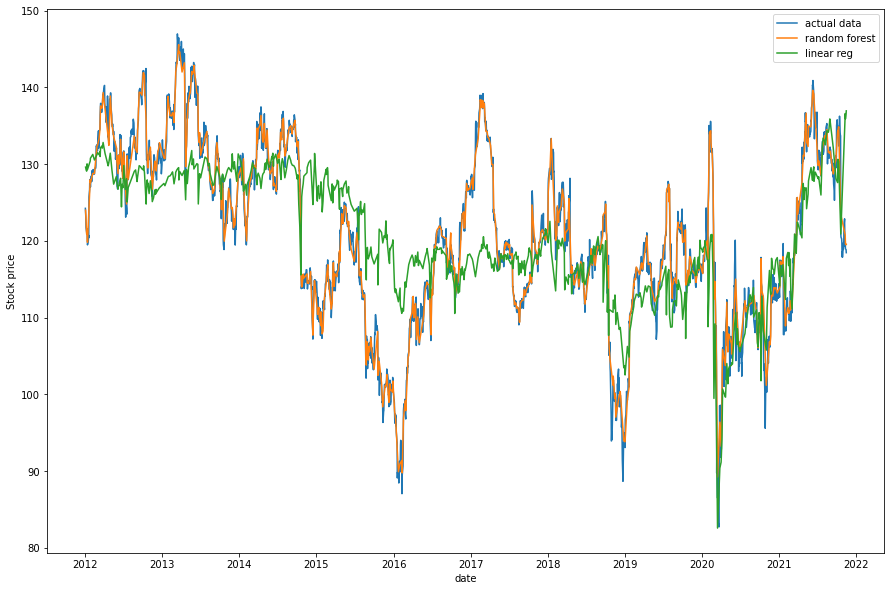

In [ ]:
#Convert data column date back into date form
for i in range(len(XX_test)):
  your_timestamp = XX_test.iloc[i,0]
  date = datetime.datetime.fromtimestamp(your_timestamp/1e9)
  XX_test.iloc[i,0] = date.date()
XX_test.date = pd.to_datetime(XX_test['date'])
#plots the Random Forrest model
#plot the predictions
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
plt.plot(data['date'],y, label ="actual data")
ax = sns.lineplot(X_test.date,ypr_rf, label ="random forest")
ax = sns.lineplot(X_test['date'],y_pred, label ="linear reg")
plt.ylabel("Stock price")
plt.show()


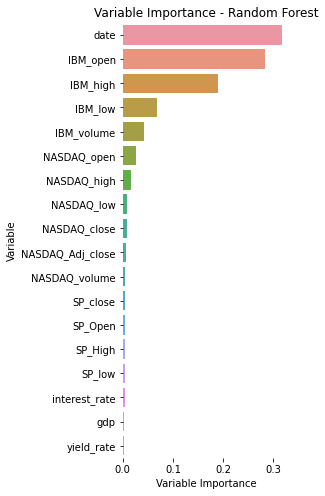

In [ ]:
#Plot variable importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1] 

f, ax = plt.subplots(figsize=(3,8))
sns.barplot(y=X.columns,x=importances[indices],label="Total")
plt.title("Variable Importance - Random Forest")
ax.set(ylabel="Variable",xlabel="Variable Importance")
sns.despine(left=True, bottom=True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,ypr_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test,ypr_rf))
print(mse)
print(rmse_rf)



0.545209670598679
0.7383831462043801
66.23829590471408
8.13869128943432
